In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import os
import logging
import pandas as pd
import os.path as op
from PIL import Image, ImageOps
from pathlib import Path

from keras.models import load_model
from keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam
from sklearn.model_selection import train_test_split
from keras import backend as K
from matplotlib import pyplot as plt

import numpy as np

print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Data properties
num_classes = 10
img_x, img_y = 128, 128

In [3]:
def load_train():
    train_images = pd.read_pickle('train_max_x')
    train_labels = pd.read_csv('train_max_y.csv').to_numpy()[:, 1]
    return train_images, train_labels

def load_test():
    return pd.read_pickle('test_max_x')

def predictions_to_csv(pred, filename):
#     if not op.isdir(RESULT_DIR):
#         os.makedirs(RESULT_DIR)
    res = pd.Series(pred, name='Label')
    submission = pd.concat([pd.Series(range(0, res.shape[0]), name='Id'), res], axis=1)
    submission.to_csv(filename, index=False)

In [4]:
# Load training data
train_images, train_labels = load_train()
x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [5]:
# Reshape and normalize images
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_valid = x_valid.reshape(x_valid.shape[0], img_x, img_y, 1)
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255.
x_valid /= 255.

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)

print(f'Train images dim: {x_train.shape}')
print(f'Train labels dim:{y_train.shape}')
print(f'Validation images dim: {x_valid.shape}')
print(f'Validation labels dim:{y_valid.shape}')

Train images dim: (40000, 128, 128, 1)
Train labels dim:(40000, 10)
Validation images dim: (10000, 128, 128, 1)
Validation labels dim:(10000, 10)


In [6]:
class VGG():
    def __init__(self, input_shape, num_classes, optimizer):
        self.model = Sequential()
        #layer1
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        #layer2
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        #layer3
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        #fully connected layer
        self.model.add(Flatten())
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(num_classes, activation='softmax'))

        self.model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
        print(self.model.summary())

    def train(self, x, y, x_valid, y_valid, batch_size=64, epochs=60, datagen=True, num_steps='auto', callbacks=None):
        if num_steps == 'auto':
            num_steps = x.shape[0] // batch_size
        if datagen:
            data_generator = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=1,
                zoom_range=0.1
            )
            self.history = self.model.fit_generator(
                data_generator.flow(x, y, batch_size=batch_size),
                steps_per_epoch=num_steps,
                epochs=epochs,
                verbose=1,
                validation_data=(x_valid, y_valid),
                callbacks=callbacks
            )
        else:
            self.history = self.model.fit(
                x, y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_valid, y_valid),
                callbacks=callbacks
            )
        return self.history

    def evaluate(self, x, y):
        return self.model.evaluate(x, y, verbose=0)

    def predict(self, x):
        return self.model.predict(x)

    def save(self, filename):
        self.model.save(filename)

In [7]:
#optimizer = Adadelta()
optimizer = Adam()
#optimizer = Adamax()
#optimizer = RMSprop()
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


# Train params
batch_size = 64
num_steps = 'auto'
# num_steps = 1000
epochs = 25
model_name = 'VGG9_2(optimizer)'

In [8]:
# Callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.85)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = ModelCheckpoint(
    filepath=f'./trained_models/{model_name}_best.h5',
    verbose=1,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    period=1)

# Adam

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 60, 32)       

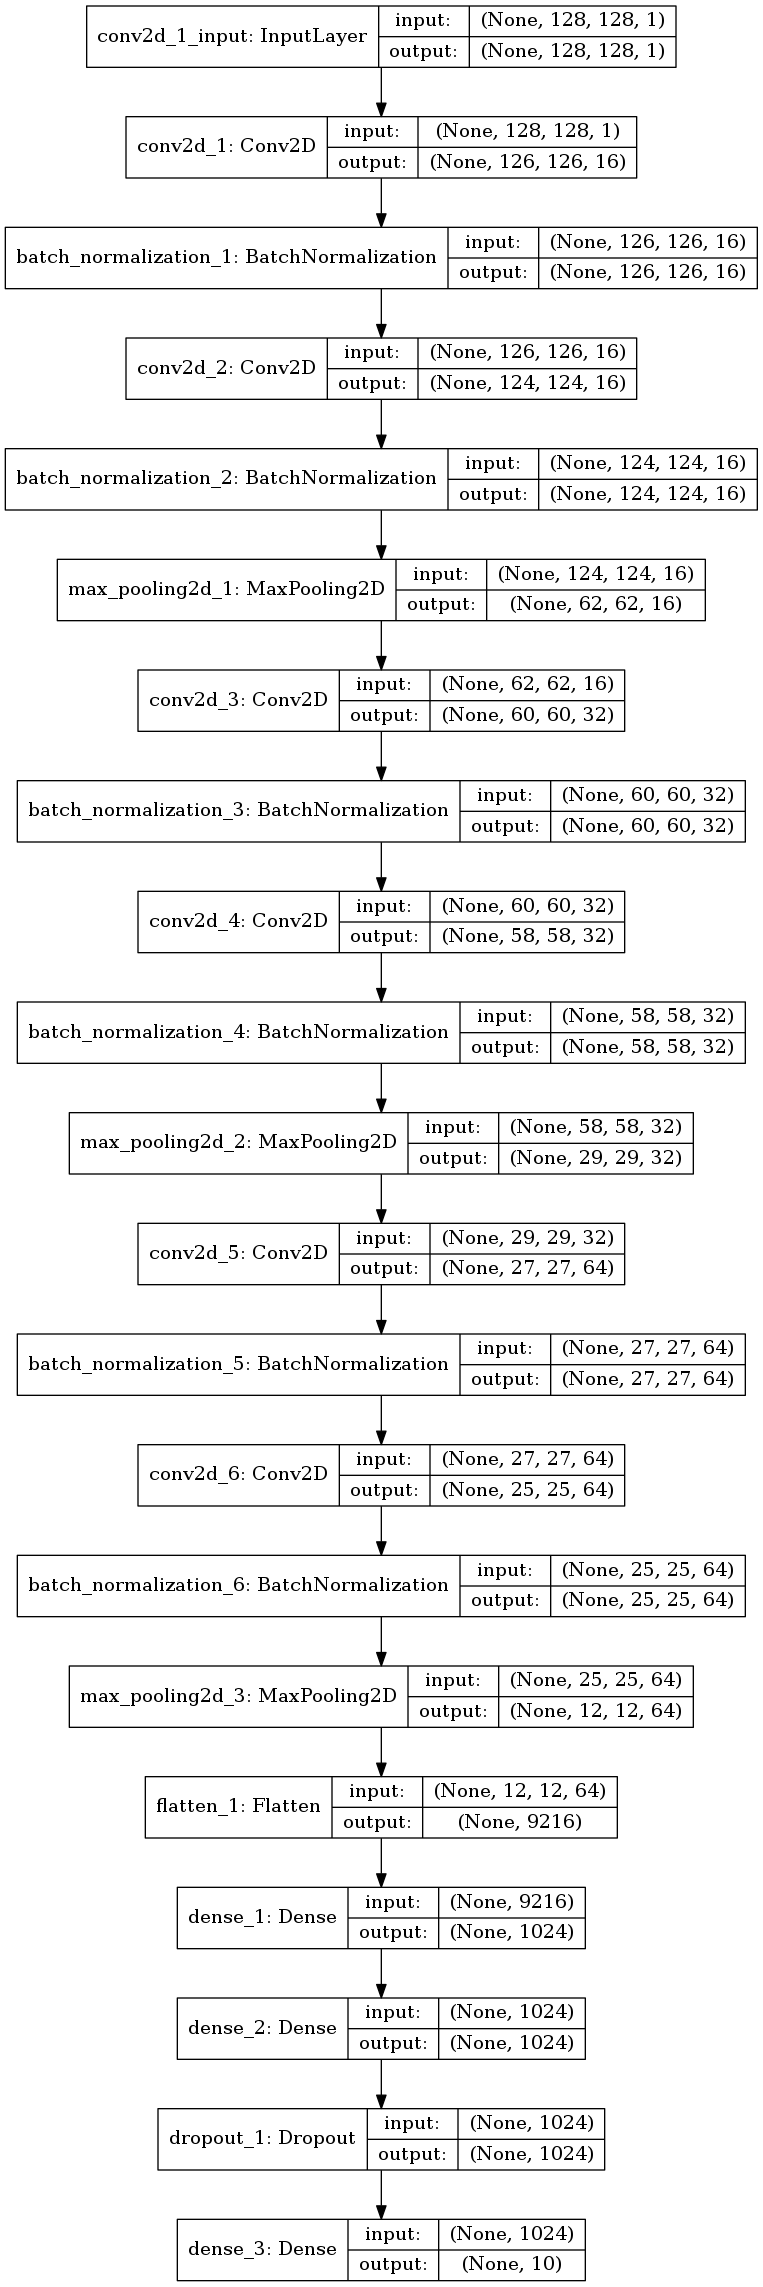

In [9]:
#Adam
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=Adam())
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [10]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, checkpoint]
    )

Epoch 1/25
625/625 [==============================] - 73s 116ms/step - loss: 2.1757 - accuracy: 0.2377 - val_loss: 1.8905 - val_accuracy: 0.2674

Epoch 00001: val_accuracy improved from -inf to 0.26740, saving model to ./trained_models/VGG9_2(optimizer)_best.h5
Epoch 2/25
625/625 [==============================] - 68s 108ms/step - loss: 1.8952 - accuracy: 0.2659 - val_loss: 1.8210 - val_accuracy: 0.2945

Epoch 00002: val_accuracy improved from 0.26740 to 0.29450, saving model to ./trained_models/VGG9_2(optimizer)_best.h5
Epoch 3/25
625/625 [==============================] - 67s 108ms/step - loss: 1.6680 - accuracy: 0.3544 - val_loss: 1.6560 - val_accuracy: 0.3965

Epoch 00003: val_accuracy improved from 0.29450 to 0.39650, saving model to ./trained_models/VGG9_2(optimizer)_best.h5
Epoch 4/25
625/625 [==============================] - 67s 108ms/step - loss: 1.2007 - accuracy: 0.5915 - val_loss: 1.0239 - val_accuracy: 0.6515

Epoch 00004: val_accuracy improved from 0.39650 to 0.65150, sa

In [11]:
score = model.evaluate(x_valid, y_valid)
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')
history_dict = history.history
adam_acc = history_dict['accuracy']
adam_val_acc = history_dict['val_accuracy']

Validation Loss: 0.22060960127189755
Validation Accuracy: 0.9452000260353088


In [12]:
# epcs = range(1, len(acc) + 1)
# plt.plot(epcs, acc, label='Training acc')
# plt.plot(epcs, val_acc, label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.savefig(f'./figures/{model_name}_{round(score[1]*100, 2)}%.png')
# plt.show()

# Adadelta

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 60, 60, 32)       

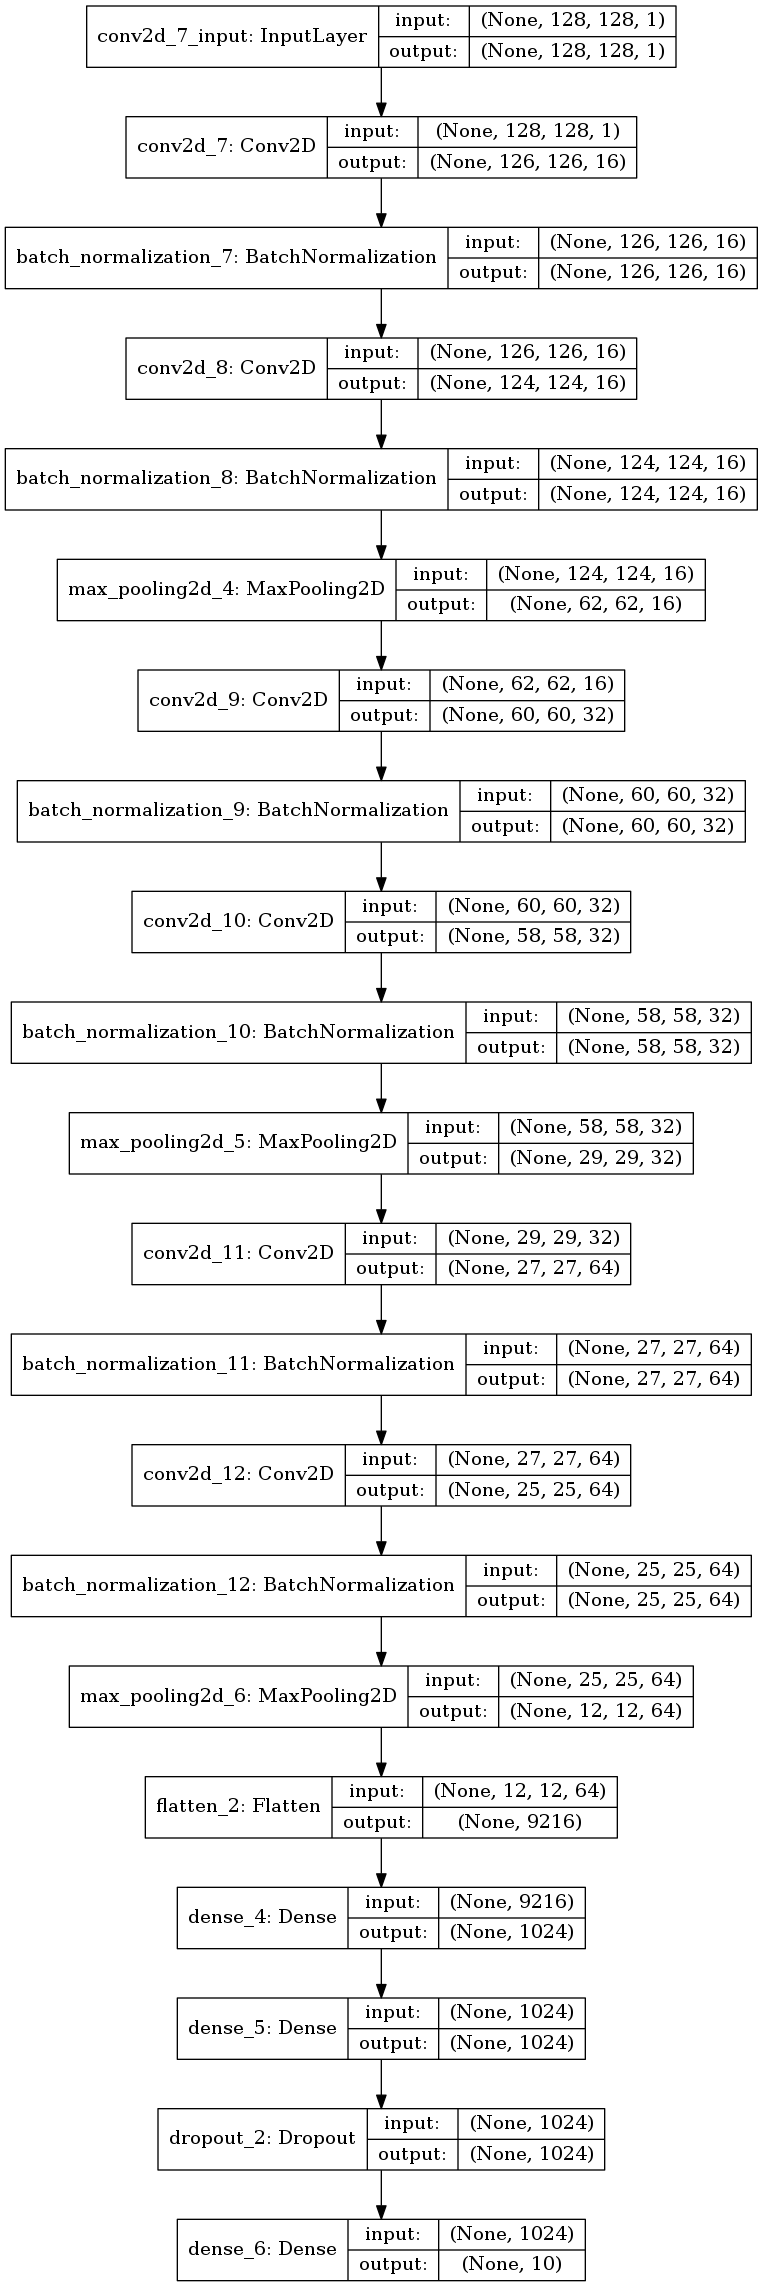

In [13]:
#Adadelta
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=Adadelta())
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [14]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, checkpoint]
    )

Epoch 1/25
625/625 [==============================] - 71s 114ms/step - loss: 2.1540 - accuracy: 0.2405 - val_loss: 1.9589 - val_accuracy: 0.2682

Epoch 00001: val_accuracy did not improve from 0.95150
Epoch 2/25
625/625 [==============================] - 69s 111ms/step - loss: 1.7734 - accuracy: 0.3147 - val_loss: 1.6058 - val_accuracy: 0.4028

Epoch 00002: val_accuracy did not improve from 0.95150
Epoch 3/25
625/625 [==============================] - 69s 111ms/step - loss: 1.2640 - accuracy: 0.5623 - val_loss: 1.2242 - val_accuracy: 0.6452

Epoch 00003: val_accuracy did not improve from 0.95150
Epoch 4/25
625/625 [==============================] - 69s 111ms/step - loss: 0.8987 - accuracy: 0.7006 - val_loss: 0.8137 - val_accuracy: 0.7413

Epoch 00004: val_accuracy did not improve from 0.95150
Epoch 5/25
625/625 [==============================] - 69s 111ms/step - loss: 0.7355 - accuracy: 0.7617 - val_loss: 0.8367 - val_accuracy: 0.7484

Epoch 00005: val_accuracy did not improve from 0.9

In [15]:
score = model.evaluate(x_valid, y_valid)
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')
history_dict = history.history
adadelta_acc = history_dict['accuracy']
adadelta_val_acc = history_dict['val_accuracy']

Validation Loss: 0.4177964359924197
Validation Accuracy: 0.9196000099182129


# Adamax

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_14 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_15 (Batc (None, 60, 60, 32)       

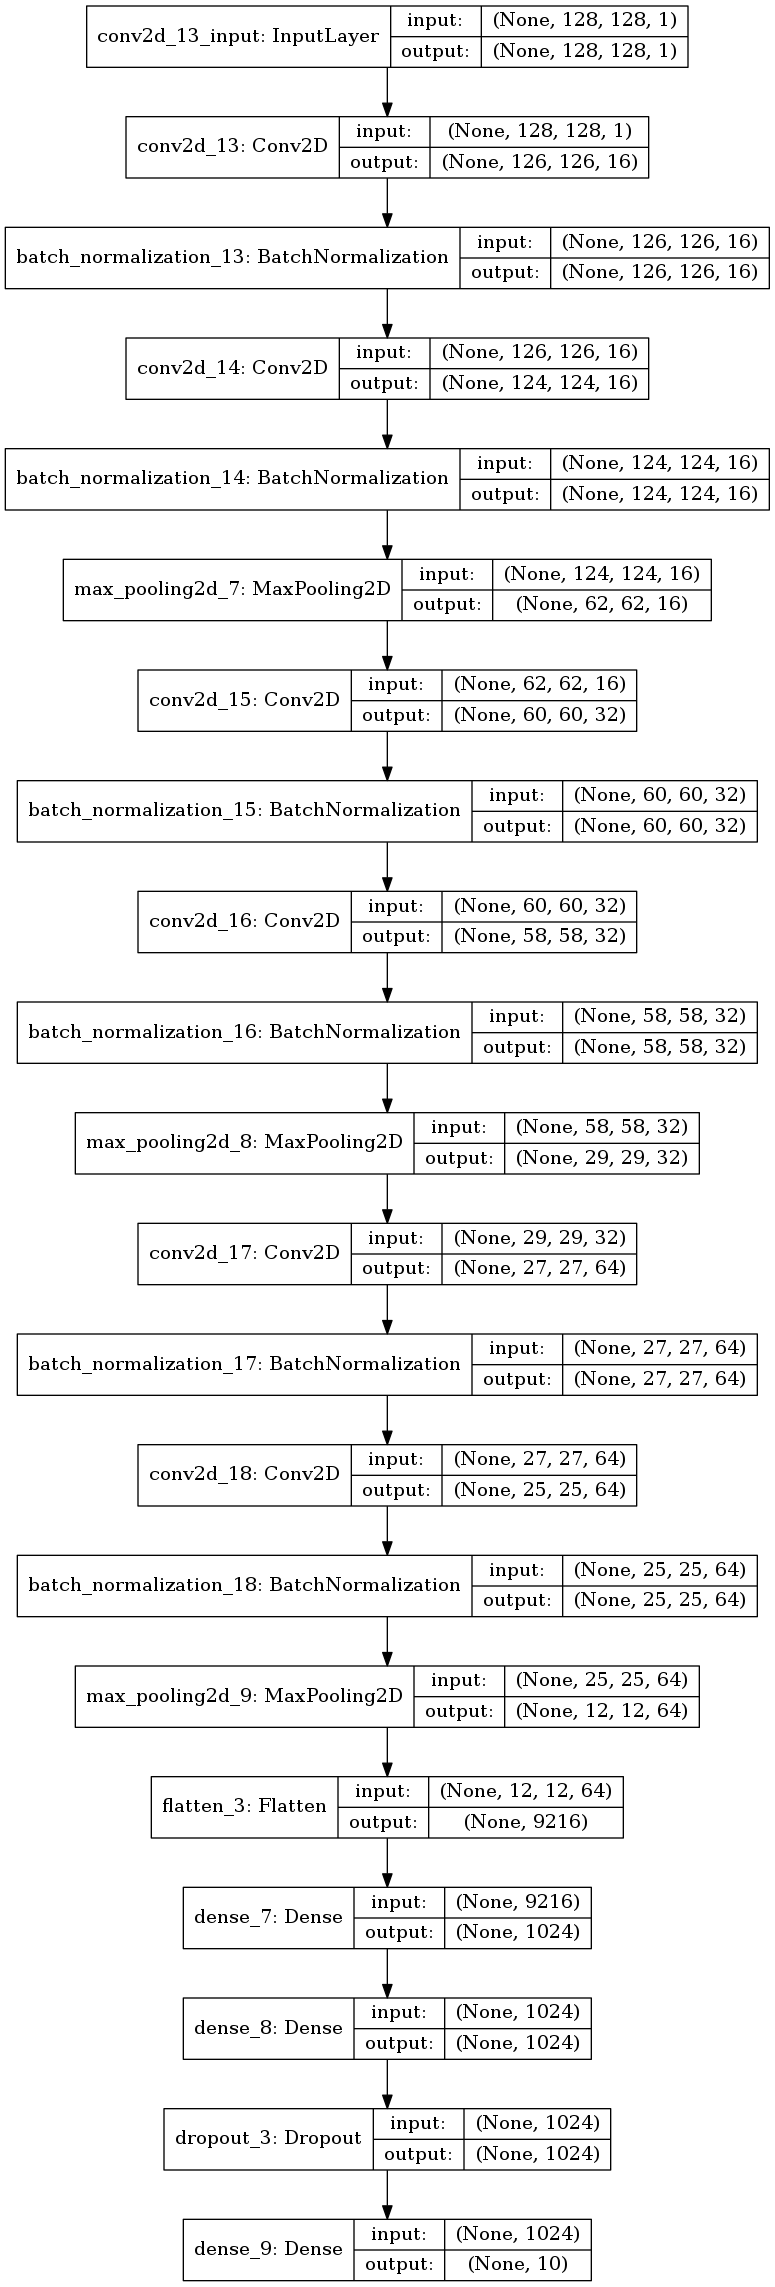

In [16]:
#Adamax
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=Adamax())
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [17]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, checkpoint]
    )

Epoch 1/25
625/625 [==============================] - 69s 110ms/step - loss: 2.2164 - accuracy: 0.2347 - val_loss: 1.9102 - val_accuracy: 0.2631

Epoch 00001: val_accuracy did not improve from 0.95150
Epoch 2/25
625/625 [==============================] - 67s 107ms/step - loss: 1.9074 - accuracy: 0.2572 - val_loss: 1.8932 - val_accuracy: 0.2652

Epoch 00002: val_accuracy did not improve from 0.95150
Epoch 3/25
625/625 [==============================] - 67s 107ms/step - loss: 1.8860 - accuracy: 0.2700 - val_loss: 2.0095 - val_accuracy: 0.2131

Epoch 00003: val_accuracy did not improve from 0.95150
Epoch 4/25
625/625 [==============================] - 67s 107ms/step - loss: 1.7265 - accuracy: 0.3486 - val_loss: 1.5755 - val_accuracy: 0.3968

Epoch 00004: val_accuracy did not improve from 0.95150
Epoch 5/25
625/625 [==============================] - 67s 107ms/step - loss: 1.5152 - accuracy: 0.4244 - val_loss: 1.5926 - val_accuracy: 0.4415

Epoch 00005: val_accuracy did not improve from 0.9

In [18]:
score = model.evaluate(x_valid, y_valid)
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')
history_dict = history.history
adamax_acc = history_dict['accuracy']
adamax_val_acc = history_dict['val_accuracy']

Validation Loss: 0.24330301229655743
Validation Accuracy: 0.9405999779701233


# RMSprop

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_19 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_20 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_21 (Batc (None, 60, 60, 32)       

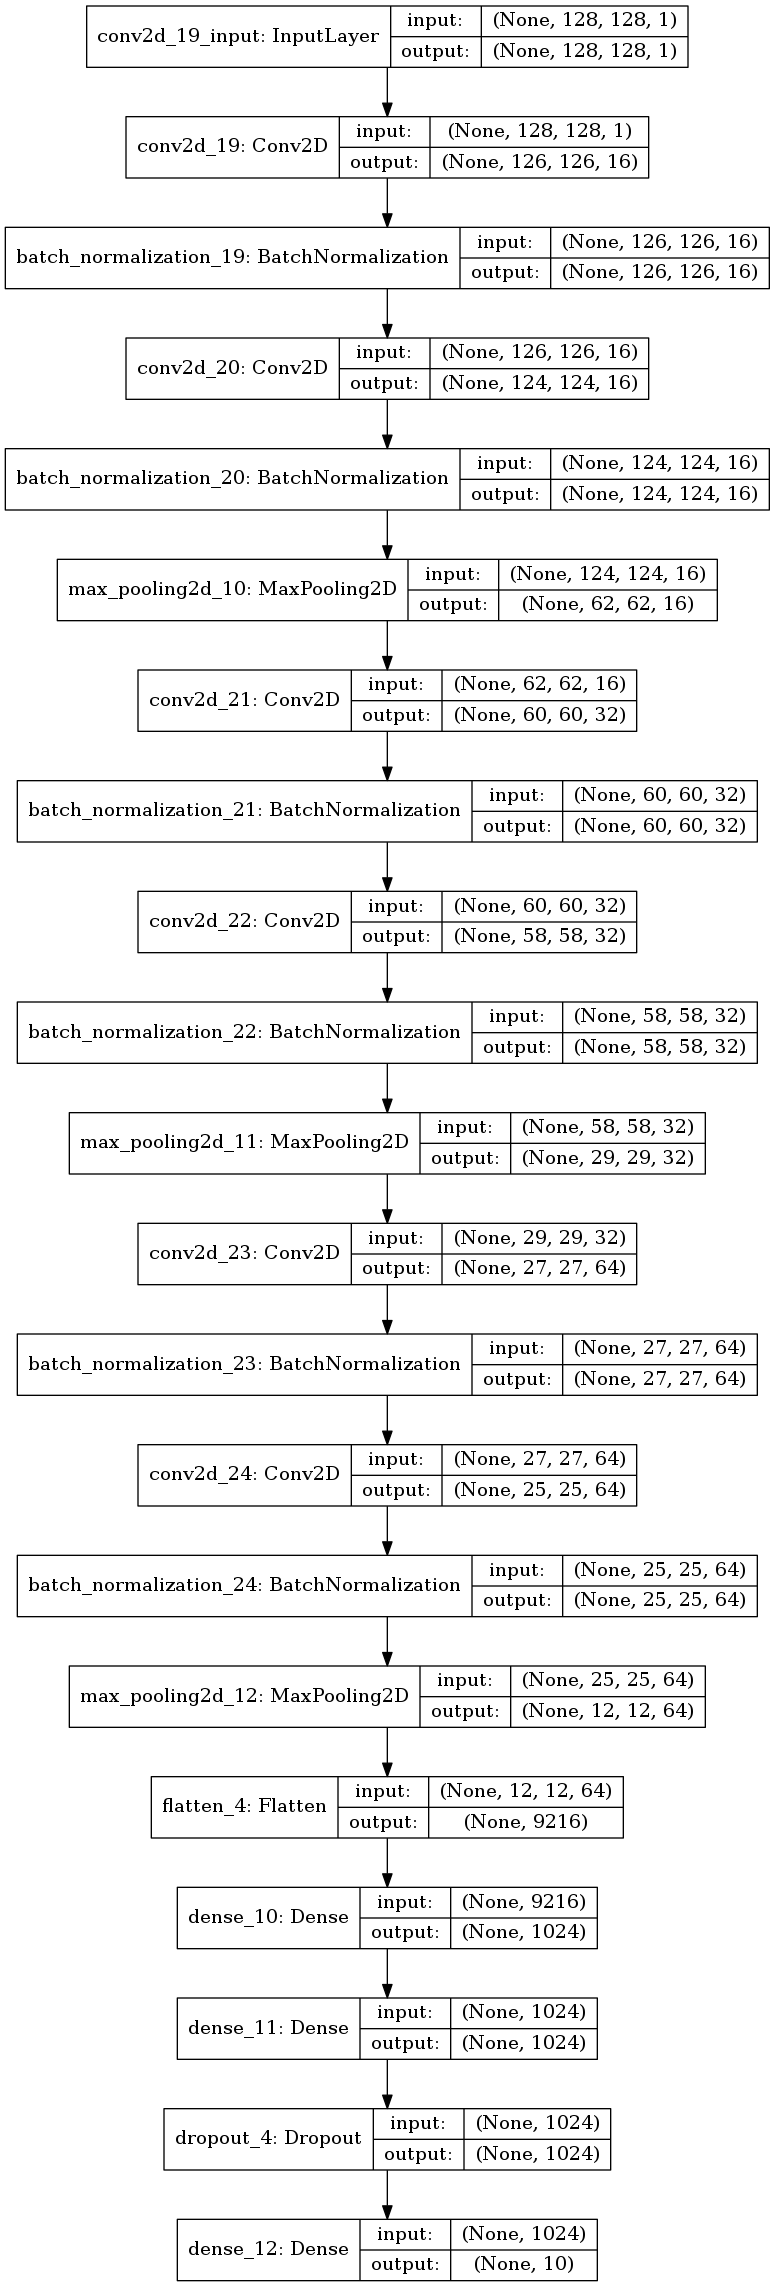

In [19]:
#RMSprop
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=RMSprop())
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [20]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, checkpoint]
    )

Epoch 1/25
625/625 [==============================] - 69s 110ms/step - loss: 2.3796 - accuracy: 0.2354 - val_loss: 1.9212 - val_accuracy: 0.2605

Epoch 00001: val_accuracy did not improve from 0.95150
Epoch 2/25
625/625 [==============================] - 67s 107ms/step - loss: 1.7867 - accuracy: 0.3112 - val_loss: 1.7650 - val_accuracy: 0.3777

Epoch 00002: val_accuracy did not improve from 0.95150
Epoch 3/25
625/625 [==============================] - 67s 107ms/step - loss: 1.3751 - accuracy: 0.5285 - val_loss: 1.1755 - val_accuracy: 0.6005

Epoch 00003: val_accuracy did not improve from 0.95150
Epoch 4/25
625/625 [==============================] - 67s 107ms/step - loss: 1.0746 - accuracy: 0.6435 - val_loss: 1.3079 - val_accuracy: 0.5518

Epoch 00004: val_accuracy did not improve from 0.95150
Epoch 5/25
625/625 [==============================] - 67s 106ms/step - loss: 0.9536 - accuracy: 0.6975 - val_loss: 1.2106 - val_accuracy: 0.7007

Epoch 00005: val_accuracy did not improve from 0.9

In [21]:
score = model.evaluate(x_valid, y_valid)
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')
history_dict = history.history
RMSprop_acc = history_dict['accuracy']
RMSprop_val_acc = history_dict['val_accuracy']

Validation Loss: 0.5253678004741669
Validation Accuracy: 0.8557000160217285


# SGD

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_25 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_26 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_27 (Batc (None, 60, 60, 32)       

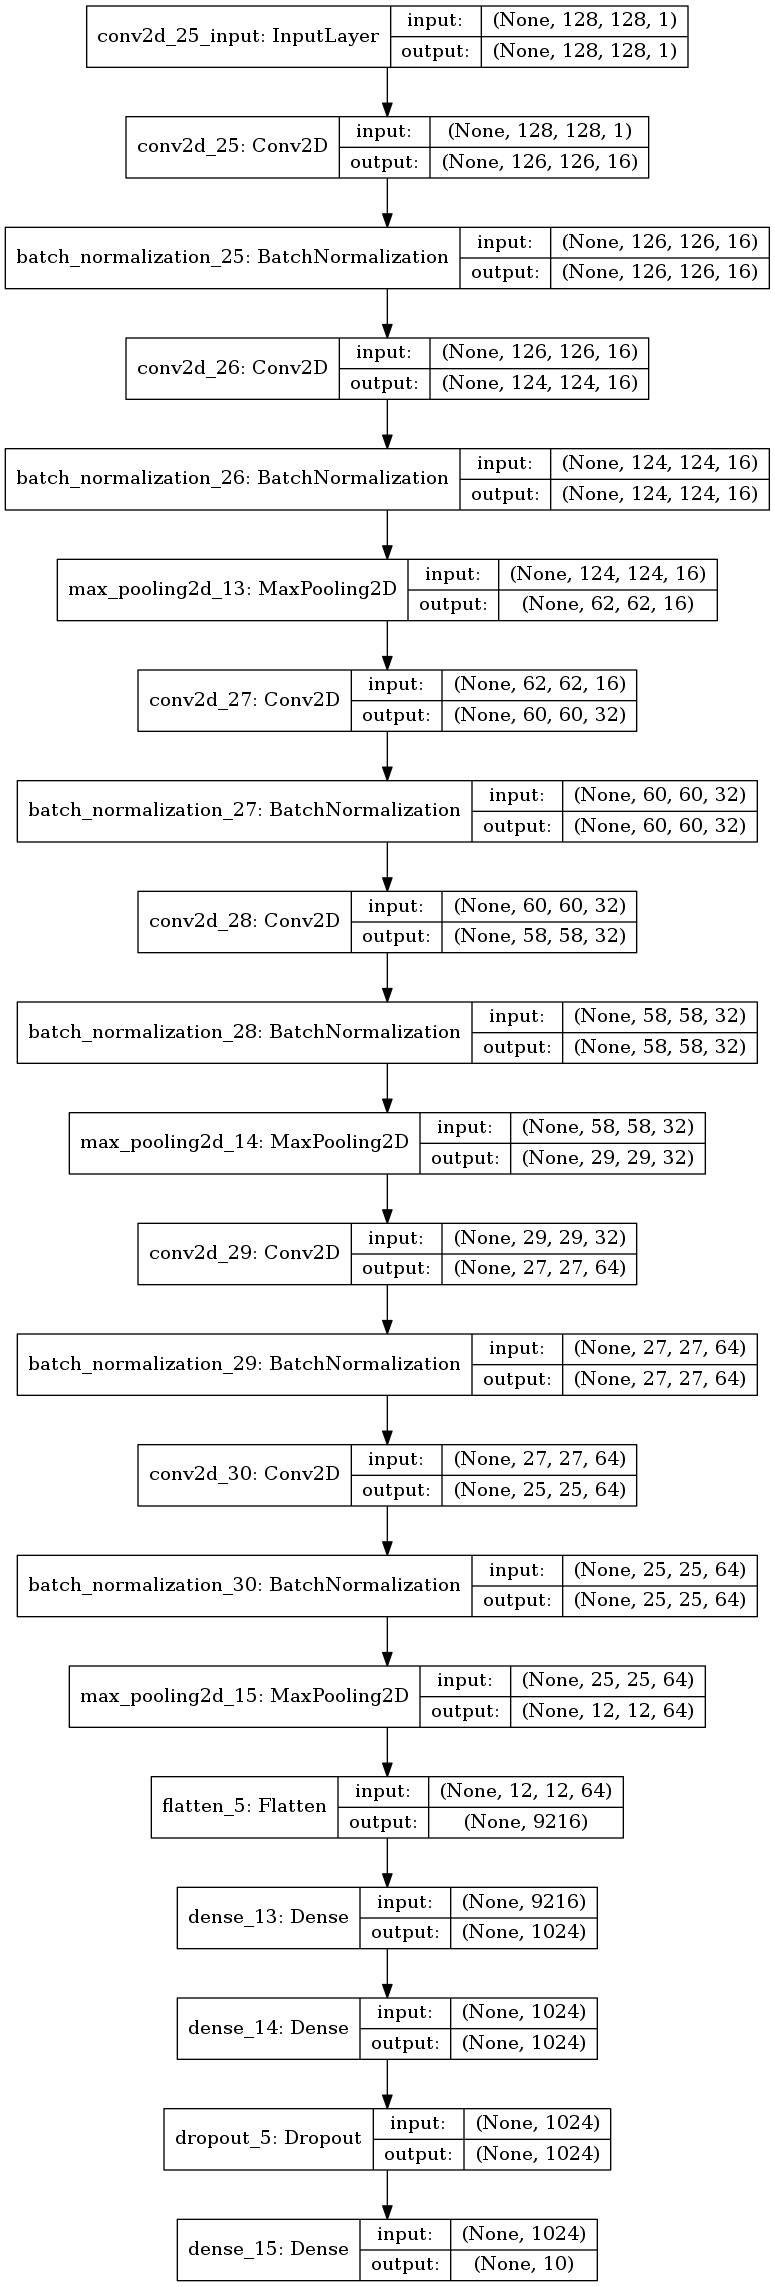

In [22]:
#SGD
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [23]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, checkpoint]
    )

Epoch 1/25
625/625 [==============================] - 67s 107ms/step - loss: 1.9819 - accuracy: 0.2470 - val_loss: 1.9062 - val_accuracy: 0.2415

Epoch 00001: val_accuracy did not improve from 0.95150
Epoch 2/25
625/625 [==============================] - 65s 105ms/step - loss: 1.9083 - accuracy: 0.2583 - val_loss: 2.0065 - val_accuracy: 0.1783

Epoch 00002: val_accuracy did not improve from 0.95150
Epoch 3/25
625/625 [==============================] - 65s 105ms/step - loss: 1.8894 - accuracy: 0.2659 - val_loss: 2.1129 - val_accuracy: 0.2187

Epoch 00003: val_accuracy did not improve from 0.95150
Epoch 4/25
625/625 [==============================] - 65s 104ms/step - loss: 1.7859 - accuracy: 0.3221 - val_loss: 1.8971 - val_accuracy: 0.2646

Epoch 00004: val_accuracy did not improve from 0.95150
Epoch 5/25
625/625 [==============================] - 65s 104ms/step - loss: 1.6080 - accuracy: 0.3895 - val_loss: 1.4880 - val_accuracy: 0.4426

Epoch 00005: val_accuracy did not improve from 0.9

In [24]:
score = model.evaluate(x_valid, y_valid)
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')
history_dict = history.history
SGD_acc = history_dict['accuracy']
SGD_val_acc = history_dict['val_accuracy']
epcs = range(1, len(SGD_acc) + 1)

Validation Loss: 0.2063505022481084
Validation Accuracy: 0.9395999908447266


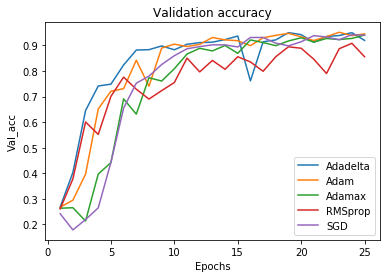

In [25]:
epcs = range(1, len(adadelta_val_acc) + 1)
plt.plot(epcs, adadelta_val_acc, label='Adadelta')
plt.plot(epcs, adam_val_acc, label='Adam')
plt.plot(epcs, adamax_val_acc, label='Adamax')
plt.plot(epcs, RMSprop_val_acc, label='RMSprop')
plt.plot(epcs, SGD_val_acc, label='SGD')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Val_acc')
plt.legend()
plt.savefig(f'./trained_models/optimizer.png')
plt.show()